# Actor Critic

In this notebook, we will implementa basic Actor Critic Reinforcement learning algorithm for Lunar Lander Environment.

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the cartpole environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![Cartpole](https://gymnasium.farama.org/_images/lunar_lander.gif)

## Actor Critic Methods

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function.

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this tutorial, both the *Actor* and *Critic* will be represented using one neural network with two outputs.




### 3. The Actor-Critic loss

Since you're using a hybrid Actor-Critic model, the chosen loss function is a combination of Actor and Critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### The Actor loss

The Actor loss is based on [policy gradients with the Critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (Actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (Critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### The Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [Advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the Critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the Critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the Critic, it may turn out that there's no Advantage ($G - V = 0$), and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

Due to the usage of this advantage function, this algorithm is also **Advantage Actor Critic (A2C)**.
<br>

#### The Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


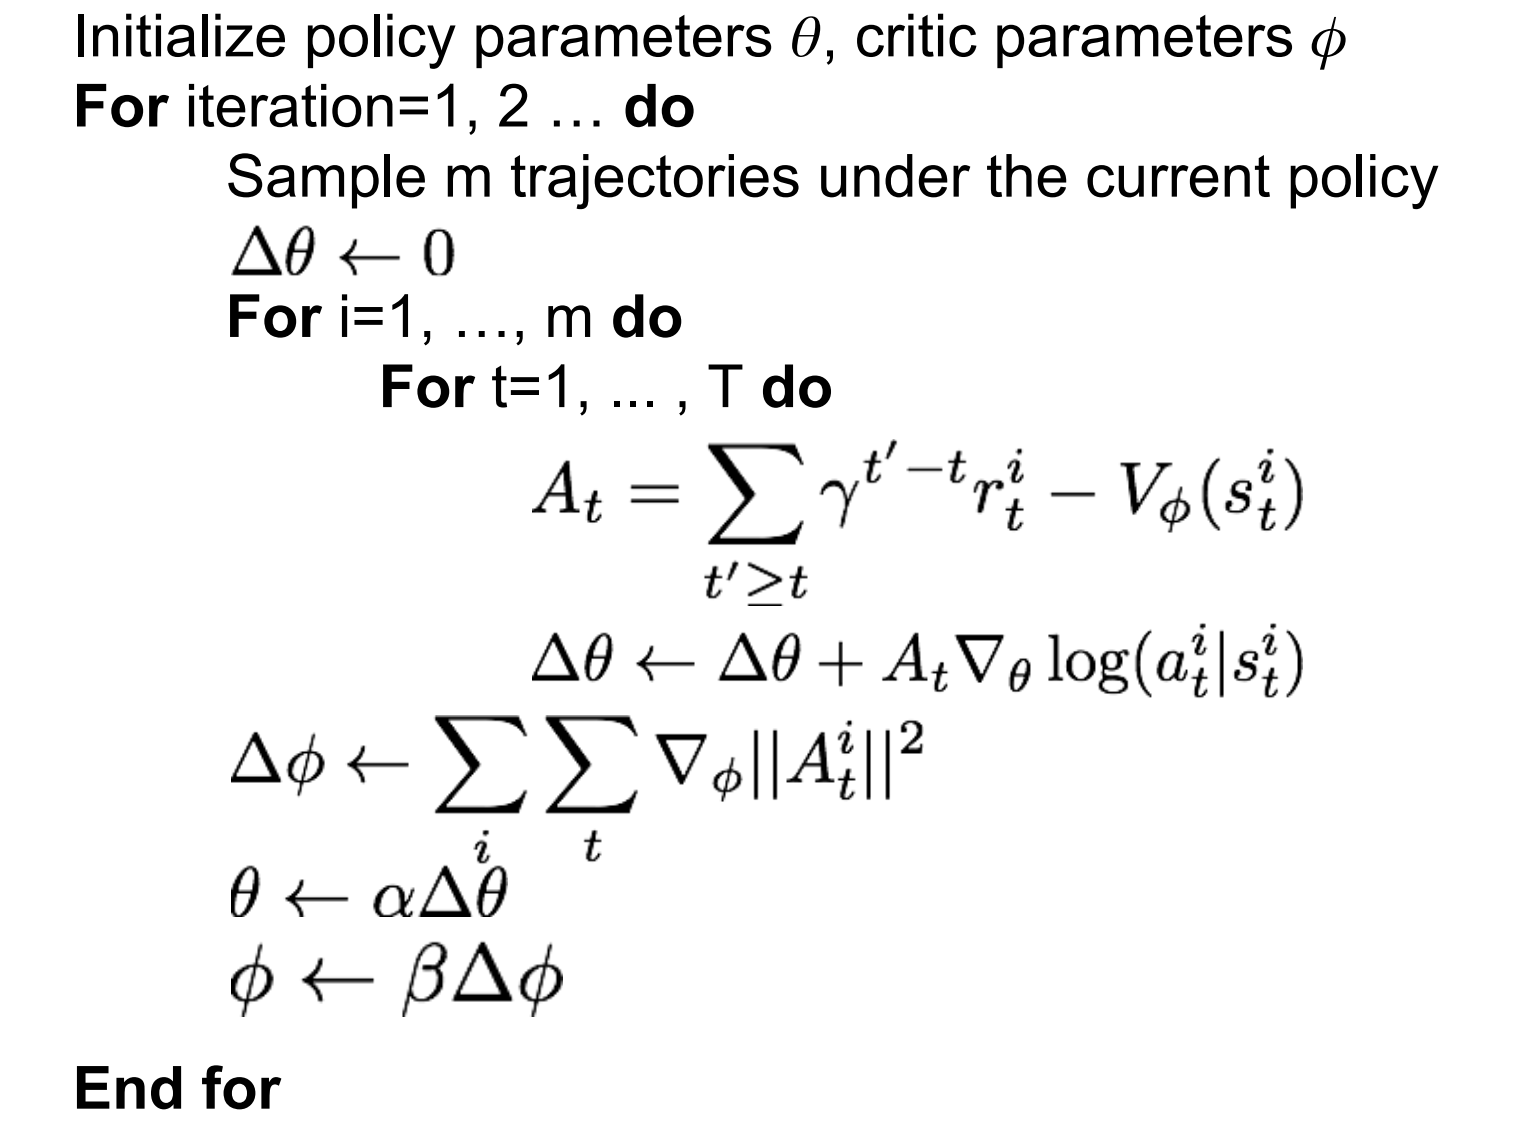

In [ ]:
!pip install -q swig
!pip install -q gym[box2d]

In [ ]:
# Combined modified code

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the environment
env = gym.make("MountainCarContinuous-v0", new_step_api=True, max_episode_steps=10000)


class ActorCritic(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(ActorCritic, self).__init__()
        self.layer1     =  nn.Linear    (n_observations, 128)
        self.ln1        =  nn.LayerNorm (128)
        self.dropout1   =  nn.Dropout   (p=0.5)

        self.layer2     =  nn.Linear    (128           , 256)
        self.ln2        =  nn.LayerNorm (256)
        self.dropout2   =  nn.Dropout   (p=0.5)

        self.layer3     =  nn.Linear    (256           , 128)
        self.ln3        =  nn.LayerNorm (128)
        self.dropout3   =  nn.Dropout   (p=0.5)

        # actor's layer
        self.mu_layer   =  nn.Linear    (128           , n_actions)
        self.std_layer  =  nn.Linear    (128           , n_actions)

        # critic's layer
        self.value_head = nn.Linear     (128, 1)

    def forward(self, x):
        x   = F.leaky_relu(self.dropout1((self.layer1(x))), negative_slope=2.0)
        x   = F.leaky_relu(self.dropout2((self.layer2(x))), negative_slope=2.5)
        x   = F.leaky_relu(self.dropout3((self.layer3(x))), negative_slope=3.0)

        # actor: choses the standard deviation for the action distribution
        action_mean  = self.mu_layer(x)
        action_std = F.softplus(self.std_layer(x))  # std must be positive, use softplus to ensure this

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)


        return action_mean, action_std, state_values

    def act(self, state, epsilon):
        state = torch.from_numpy(state).float().to(device)

        action_mean, action_std, state_value = self.forward(state)

        # create a normal distribution over the actions
        m = Normal(action_mean, action_std)

        # sample an action
        if random.random() < epsilon:
            action = torch.tensor([random.choice(range(action_size))])  # Random action
        else:
            action = m.sample()

        action = torch.tanh(action)

        return action.cpu().numpy(), m.log_prob(action.to(device)).item(), state_value



# Here, we will specify the hyperparameters
MIDDLE_POSITION = 0.0  # Define the middle of the environment
THRESHOLD = 0.1  # Define the threshold for the middle area
total_episodes = 200  # Total training episodes
max_steps = 2000000  # Max steps per episode
learning_rate = 1e-3  # Learning rate
gamma = 0.99  # Discounting rate
epsilon = 0.1  # Exploration rate
batch_size = 10  # Batch size for updates
epsilon_start = 0.1
epsilon_final = 0.01
epsilon_decay = 500  # Larger values mean a slower decay

def get_epsilon(step):
    return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * 0.0003)


print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('state size:', state_size)
print('action size:', action_size)

# Intialize policy network
actor_critic = ActorCritic(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.RMSprop(actor_critic.parameters(), lr=learning_rate)

goal_position = 0.5  # Define the goal position

scores = []
batch_rewards = []
batch_log_probs = []

for episode in range(1, total_episodes+1):
    saved_buffer = {'log_prob':[], 'value':[]}
    saved_log_probs = []
    rewards = []
    state = env.reset()

    # collect trajectory
    for t in range(1, max_steps + 1):
        # sample action and its log_prob from policy
        epsilon = get_epsilon(t)
        action, log_prob, value = actor_critic.act(state, epsilon)
        state, reward, terminated, truncated, _ = env.step(action)
        if abs(state[0] - MIDDLE_POSITION) <= THRESHOLD or t > 1000:
            reward -= 0.1  # Only penalize if in the middle
        reward += (goal_position - abs(state[0])) / goal_position   # Adjust the reward based on the distance to the goal
        rewards.append(reward)
        batch_rewards.append(reward)
        batch_log_probs.append(log_prob)

        if terminated or truncated:
            break

    scores.append(sum(rewards))

    if episode % batch_size == 0:
        # Compute the discounted returns at each timestep
        returns = deque(maxlen=max_steps)
        n_steps = len(batch_rewards)

        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns) > 0 else 0)
            returns.appendleft(gamma * disc_return_t + batch_rewards[t])

        # standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        policy_losses = []  # list to save actor (policy) loss
        value_losses = []  # list to save critic (value) loss

        for log_prob, value, R in zip(batch_log_probs, saved_buffer["value"], returns):
            advantage = R - value.item()

            # calculate actor (policy) loss
            policy_losses.append(-log_prob * advantage)

            # calculate critic (value) loss using L1 smooth loss
            value_losses.append(F.smooth_l1_loss(value, torch.tensor([R], device=device)))

        if policy_losses and value_losses:
            # sum up all the values of policy_losses and value_losses
            loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
            loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
            # Back propagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(actor_critic.parameters(), max_norm=1.0)
            optimizer.step()

        # Clear the batch
        batch_rewards = []
        batch_log_probs = []

    print(f"Episode {episode}: Reward = {scores[-1]}, Done: {terminated}")



observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
state size: 2
action size: 1
Episode 1: Reward = -84.9108846205246, Done: False
Episode 2: Reward = -86.36726125729584, Done: False
Episode 3: Reward = -71.44380381495313, Done: False
Episode 4: Reward = -60.52883298827519, Done: False
Episode 5: Reward = -84.95843785501918, Done: False
Episode 6: Reward = -80.2379469031211, Done: False
Episode 7: Reward = -51.44387261486426, Done: False
Episode 8: Reward = -73.43108129703336, Done: False
Episode 9: Reward = -95.51800609597214, Done: False
Episode 10: Reward = -62.148160948288435, Done: False
Episode 11: Reward = -90.27931156465765, Done: False
Episode 12: Reward = 67.40161392946703, Done: True
Episode 13: Reward = -87.29876775051099, Done: False
Episode 14: Reward = -92.74312573536892, Done: False
Episode 15: Reward = -68.81871779209234, Done: False
Episode 16: Reward = -66.6116323475321, Done: False
Episode 17: Reward = -124.

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create the environment
env = gym.make("MountainCarContinuous-v0", new_step_api= True, max_episode_steps = 100000)

### Actor Critic Network

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(ActorCritic, self).__init__()
        self.layer1     =  nn.Linear    (n_observations, 128)
        self.ln1        =  nn.LayerNorm (128)
        self.dropout1   =  nn.Dropout   (p=0.5)

        self.layer2     =  nn.Linear    (128           , 256)
        self.ln2        =  nn.LayerNorm (256)
        self.dropout2   =  nn.Dropout   (p=0.5)

        self.layer3     =  nn.Linear    (256           , 128)
        self.ln3        =  nn.LayerNorm (128)
        self.dropout3   =  nn.Dropout   (p=0.5)

        # actor's layer
        self.mu_layer   =  nn.Linear    (128           , n_actions)
        self.std_layer  =  nn.Linear    (128           , n_actions)

        # critic's layer
        self.value_head = nn.Linear     (128, 1)

    def forward(self, x):
        x   = F.leaky_relu(self.dropout1((self.layer1(x))), negative_slope=2.0)
        x   = F.leaky_relu(self.dropout2((self.layer2(x))), negative_slope=2.5)
        x   = F.leaky_relu(self.dropout3((self.layer3(x))), negative_slope=3.0)

        # actor: choses the standard deviation for the action distribution
        action_mean  = self.mu_layer(x)
        action_std = F.softplus(self.std_layer(x))  # std must be positive, use softplus to ensure this

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)


        return action_mean, action_std, state_values

    def act(self, state):
        state = torch.from_numpy(state).float().to(device)

        action_mean, action_std, state_value = self.forward(state)

        # create a normal distribution over the actions
        m = Normal(action_mean, action_std)

        # sample an action
        action = m.sample()
        action  = torch.tanh(action)                                              # apply tanh to the action space

        # return action as numpy array, log_prob as scalar, and state_value as scalar
        return action.cpu().numpy(), m.log_prob(action).item(), state_value


### Hyperparameters

In [ ]:
# Here, we will specify the hyperparameters

total_episodes  = 2000                                                            # Total training episodes
max_steps       = 2000000                                                         # Max steps per episode
learning_rate   = 1e-3                                                            # Learning rate|
gamma           = 0.99999                                                         # Discounting rate

### Training

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
state size: 2
action size: 1


In [ ]:
# Intialize policy network
actor_critic = ActorCritic(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

In [ ]:
MIDDLE_POSITION = 0.0  # Define the middle of the environment
THRESHOLD = 0.1  # Define the threshold for the middle area

scores = []
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  saved_buffer = {'log_prob':[], 'value':[]}
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob, value = actor_critic.act(state)
    state, reward, terminated, truncated,_ = env.step(action)
    if abs(state[0] - MIDDLE_POSITION) <= THRESHOLD and t < 1000:
      reward -= 0.1  # Only penalize if in the middle
    rewards.append(reward)
    saved_buffer["log_prob"].append(log_prob)
    saved_buffer["value"].append(value)
    if terminated or truncated:
        break

  scores.append(sum(rewards))

  # Compute the discounted returns at each timestep
  returns = deque(maxlen=max_steps)
  n_steps = len(rewards)
  # We will use the dynamic programming approach to reduce complexity of this operation.
  # We calculate from last to first and avoid redundant computations that would be needed
  # if we were to do it from first to last.

  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + rewards[t]   )

  ## standardization of the returns is employed to make training more stable
  eps = np.finfo(np.float32).eps.item()
  ## eps is the smallest representable float, which is
  # added to the standard deviation of the returns to avoid numerical instabilities
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  policy_losses = [] # list to save actor (policy) loss
  value_losses = [] # list to save critic (value) loss

  for log_prob, value, R in zip(saved_buffer["log_prob"], saved_buffer["value"], returns):
    advantage = R - value.item()

    # calculate actor (policy) loss
    policy_losses.append(-log_prob * advantage)

    # calculate critic (value) loss using L1 smooth loss
    value_losses.append(F.smooth_l1_loss(value, torch.tensor([R], device=device)))

  # sum up all the values of policy_losses and value_losses
  loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

  # Back propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  print(f"Episode {episode}: Reward = {scores[-1]}, Done: {terminated}")


Episode 1: Reward = 62.74249504850617, Done: True
Episode 2: Reward = 22.53089119871524, Done: True
Episode 3: Reward = -69.12317917708407, Done: False
Episode 4: Reward = -66.50003159141426, Done: False
Episode 5: Reward = -69.54083963542129, Done: False
Episode 6: Reward = -57.04253720595776, Done: False
Episode 7: Reward = -69.77951377383428, Done: False
Episode 8: Reward = -52.42849545456758, Done: False
Episode 9: Reward = -52.088439055120254, Done: False
Episode 10: Reward = 43.73984273665017, Done: True
Episode 11: Reward = 62.26323636258387, Done: True
Episode 12: Reward = -50.64051370547606, Done: False
Episode 13: Reward = -58.13805746508236, Done: False
Episode 14: Reward = -45.3936410611959, Done: False
Episode 15: Reward = -43.77207962717358, Done: False
Episode 16: Reward = -49.039522680778795, Done: False
Episode 17: Reward = -42.966819021573954, Done: False
Episode 18: Reward = -53.18876884118014, Done: False
Episode 19: Reward = -44.34225688696651, Done: False
Episode 

Text(0, 0.5, 'Reward')

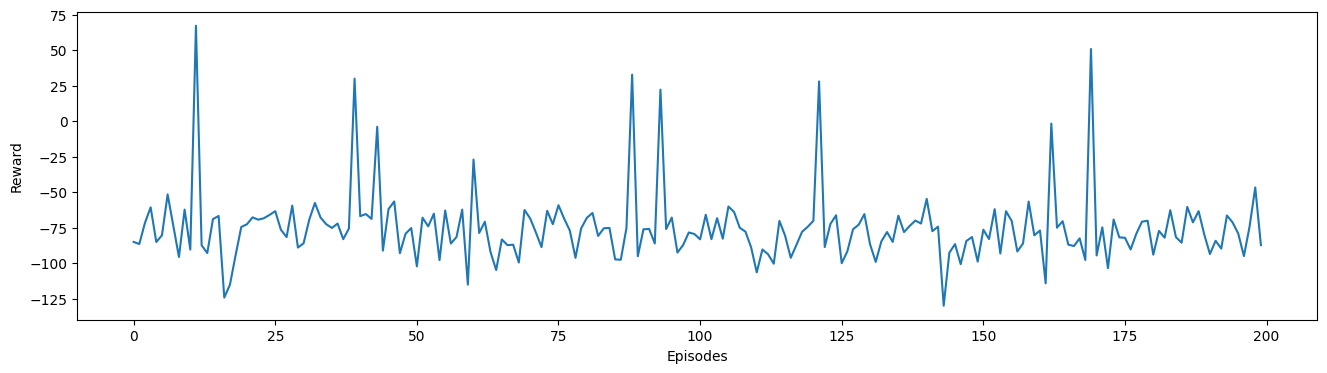

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action, _, _ = actor_critic.act(state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if terminated or truncated:
            break
    vid.close()
    env.close()

In [ ]:
show_video_of_model("MountainCarContinuous-v0")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initializati

In [ ]:
show_video("MountainCarContinuous-v0")